### Using Mallet to generate a Topic Model for the LDA_article Corpus Richard generated in 2018-06-27

In [2]:
import pandas as pd
from scopus import ScopusAbstract
from scopus import ScopusSearch
import pickle
import numpy
import re

In [67]:
import matplotlib as plt

In [3]:
import os
import os.path
from os import listdir
from os.path import isfile, join, expanduser
import shutil

In [4]:
from textblob import TextBlob 
import nltk
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer

### Setup

In [5]:
std_date_format = '%Y-%m-%d'    
home_path = expanduser("~")

### Main Code

### Load csv for all paper abstracts

Note: this excel file was extracted using the "combined_unduplicated" sheet in the file Richard produced on 2018-06-27 "WoS_Scopus_combined_updated.xlsx"

In [6]:
df_ab = pd.read_excel("Corpus_from_Richard_analysis_2018_06_27.xlsx")

In [7]:
len(df_ab)

1478

In [24]:
# remove articles that do not have an abstract
df_ab['Abstract'] = df_ab['Abstract'].astype(str)
rowsToDelete = []
for i, row in df_ab.iterrows():        
    if len(row['Abstract'])<2: rowsToDelete.append(i)

In [25]:
rowsToDelete

[57, 64, 91, 101, 145, 155, 178, 227, 1477]

In [27]:
df_ab = df_ab.drop(rowsToDelete)
len(df_ab)

1469

## Should I include titles as an addition to each Abstract?

##### capture journal names, put into a counter

In [29]:
import collections
from collections import defaultdict
journal_count = defaultdict(int)

In [30]:
for i, row in df_ab.iterrows():    
    journal_count[row['Publication']]+=1

In [31]:
df_journal_count = pd.DataFrame.from_dict(journal_count, orient="index")

In [32]:
df_journal_count = df_journal_count.sort_values(0, ascending=False)

In [33]:
df_journal_count.columns=["articleCounts"]

In [34]:
df_journal_count.head(2)

,articleCounts
"International Conference on Information and Knowledge Management, Proceedings",136
Knowledge-Based Systems,40


In [35]:
df_journal_count.to_csv("df_publication_count_June18_Analysis.csv")

### Preprocessing abstracts

In [38]:
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1469 entries, 0 to 1476
Data columns (total 6 columns):
Article_signifier    1469 non-null object
Year                 1469 non-null int64
Author               1469 non-null object
Title                1469 non-null object
Publication          1469 non-null object
Abstract             1469 non-null object
dtypes: int64(1), object(5)
memory usage: 80.3+ KB


To make things easier, changing the column names of the dataframe

In [39]:
df_ab.columns = ['pkey', 'year', 'authors', 'title', 'publicationName', 'abstract']

In [40]:
# some abstracts are NaN; filter these out
df_ab['abstract'] = df_ab['abstract'].fillna("-")

Need to get rid of Copyright tags in footers such as: _© 2012 Elsevier B.V. All rights reserved._
Strategy: look for regex that matchines between © 20 and .

Examples: "© 2014 Copyright Taylor and Francis Group, LLC."; "Copyright is held by the owner/author(s).", "Copyright 2013 ACM."
-therefore, not all footers have copyright symbol, but they do have the word capitalized


In [41]:
symbol_pattern = "©(.*)"
word_pattern = "Copyright(.*)"
df_ab["abstract_cleaned"] = "" # prep column

for i, row in df_ab.iterrows():    
    if len(row["abstract"])>1:
        if "Copyright" in row["abstract"]:         
            abstract_cleaned = re.sub(word_pattern, "", row["abstract"])
        elif "©" in row["abstract"]:
            abstract_cleaned = re.sub(symbol_pattern, "", row["abstract"])
        else:
            abstract_cleaned = row["abstract"]
    df_ab.loc[i,"abstract_cleaned"]= abstract_cleaned.replace("All rights reserved", "")

In [46]:
df_ab.head(2)

,pkey,year,authors,title,publicationName,abstract,abstract_cleaned
0,academic autonomy beyond the nation-state the ...,2018,"Baier, C; Gengnagel, V",Academic Autonomy Beyond the Nation-State The ...,OSTERREICHISCHE ZEITSCHRIFT FUER SOZIOLOGIE,The social sciences and humanities (SSH) tradi...,The social sciences and humanities (SSH) tradi...
1,exploring hidden factors behind online food sh...,2018,"Heng, Y; Gao, ZF; Jiang, Y; Chen, XQ",Exploring hidden factors behind online food sh...,JOURNAL OF RETAILING AND CONSUMER SERVICES,Despite the popularity of online food and groc...,Despite the popularity of online food and groc...


How many rows have NaN abstracts?

In [49]:
df_ab['publicationName'].nunique()

654

Now, save this file as csv (will be used in processing LDA output)

In [50]:
df_ab.to_csv("article_list_June18_Analysis.csv")

Now ready to pre-process abstract column

In [51]:
abstracts_all = df_ab['abstract_cleaned']

### now, pre-process the text for LDA topic modeling

In [52]:
import gensim
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.hdpmodel import HdpModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet
from gensim.corpora.dictionary import Dictionary
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to /Users/Tim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##### Preprocessing methods

In [53]:
en_stopwords_path = home_path+'/nltk_data/corpora/stopwords/english'
en_stopwords = [line.rstrip('\n') for line in open(en_stopwords_path)]

In [55]:
def removeStopWordsAndSingularizePhrase(phrase): # remove personal pronouns , articles, prepositions; this helps clean phrases for comparison
    #phrase = unidecode(phrase) # for simplicity, only working in ASCII, need to look for a pythonic way of doing this that is not dependent on a package    
    #phrase = phrase.replace("-", " ") # replace dashes with periods
    phrase = phrase.replace("'s", "") 
    phrase = phrase.replace(",", "")     
    phrase_tb = TextBlob(phrase)
    #stemmer = PorterStemmer()
    wordnet_lemmatizer = WordNetLemmatizer() # more here: http://textminingonline.com/dive-into-nltk-part-iv-stemming-and-lemmatization
    phrase_clean = ""
    for word in phrase_tb.words:
        if len(word)>1: # this may be controversial
            regex_pattern = re.compile(r'\b%s\b'%word, re.I)  
            #if word not in en_stopwords+["the", "a"]: # this will not match case insensitivity 
            wordInStopWordsFlag = False # default
            for stopword in en_stopwords+["the", "a"]: # this is a more robust alternative approach
                if regex_pattern.search(stopword): # note: this is the wide matching condition, contrast this to equality matching                                                    
                    wordInStopWordsFlag = True
                    break
            if wordInStopWordsFlag==False:
                word_replacement = wordnet_lemmatizer.lemmatize(word)
                #if word_replacement != word:                 
                #    word_replacement = word_replacement+"*" # this indicates a phrase has been stemmed
                #    #print "word_replacement:", word_replacement
                phrase_clean=phrase_clean+word_replacement+" "  
    return phrase_clean.strip()

In [56]:
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text)#, pos='v')

In [57]:
def preprocess(text):
    result = []
    text_cleaned = text
    text_cleaned = re.sub("All rights reserved\.","",text_cleaned, flags=re.IGNORECASE)    
    for sent in sent_tokenize(text_cleaned):
        #print (sent)
        for word in word_tokenize(sent):            
            #print (word)
            word_cleaned = removeStopWordsAndSingularizePhrase(word).lower()            
            if word_cleaned not in en_stopwords and len(word_cleaned) > 3:
                #print (word_cleaned)
                result.append(word_cleaned)
    #        result.append(lemmatize_stemming(token))
    #for token in gensim.utils.simple_preprocess(text_cleaned):
    #    if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
    #        result.append(lemmatize_stemming(token))
    return result

#### Sample document - this is testing the preprocessing method

In [58]:
# sample doc
abstracts_all[0]

'The social sciences and humanities (SSH) traditionally have a close relationship to the nation-state and there are substantial disciplinary differences across countries. Drawing on Bourdieu\'s theory of the academic field, the present article examines how academic autonomy and heteronomy are applied as discursive strategies as the SSH compete for funding in the transnational European arena established by the European Research Council (ERC). To this end, we analyze mission statements of ERC Starting Grant projects in the SSH, using a mixed methods approach of statistical text analysis (topic modeling) and qualitative content analysis. Although the ERC puts the SSH under the constraints of academic capitalism, the classical humanities secure a strong position by signaling academic autonomy and engaging in the construction and consecration of European culture. However, economics and other social sciences gravitate toward a more heteronomous self-representation, emphasizing the political 

In [59]:
# sample doc
print(preprocess(abstracts_all[0]))

['social', 'science', 'humanity', 'traditionally', 'close', 'relationship', 'nation-state', 'substantial', 'disciplinary', 'difference', 'across', 'country', 'drawing', 'bourdieu', 'theory', 'academic', 'field', 'present', 'article', 'examines', 'academic', 'autonomy', 'heteronomy', 'applied', 'discursive', 'strategy', 'compete', 'funding', 'transnational', 'european', 'arena', 'established', 'european', 'research', 'council', 'analyze', 'mission', 'statement', 'starting', 'grant', 'project', 'using', 'mixed', 'method', 'approach', 'statistical', 'text', 'analysis', 'topic', 'modeling', 'qualitative', 'content', 'analysis', 'although', 'constraint', 'academic', 'capitalism', 'classical', 'humanity', 'secure', 'strong', 'position', 'signaling', 'academic', 'autonomy', 'engaging', 'construction', 'consecration', 'european', 'culture', 'however', 'economics', 'social', 'science', 'gravitate', 'toward', 'heteronomous', 'self-representation', 'emphasizing', 'political', 'social', 'utility',

#### Now, clean all documents

In [60]:
# all docs
processed_docs = [preprocess(abstract) for abstract in abstracts_all]

In [308]:
processed_docs_as_string = [' '.join(doc) for doc in processed_docs ]

#### should we pre-process phrases?

This could be informed by trigram and bigram analysis

In [68]:
import nltk
from nltk.util import ngrams
import collections
from collections import Counter
bigrams_counter = collections.Counter()
trigrams_counter = collections.Counter()

In [69]:
for abstract_processed in processed_docs:
    bigrams = ngrams(abstract_processed,2)
    trigrams = ngrams(abstract_processed,3)
    bigrams_counter.update(bigrams)
    trigrams_counter.update(trigrams)

In [70]:
print ('Most common trigrams:')
for letter, count in trigrams_counter.most_common(50):
    print ('%s: %7d' % (letter, count))

Most common trigrams:
('latent', 'dirichlet', 'allocation'):     388
('experimental', 'result', 'show'):      68
('dirichlet', 'allocation', 'model'):      65
('probabilistic', 'topic', 'model'):      58
('latent', 'semantic', 'analysis'):      55
('natural', 'language', 'processing'):      44
('probabilistic', 'latent', 'semantic'):      36
('proceeding', 'contain', 'paper'):      34
('based', 'latent', 'dirichlet'):      31
('social', 'medium', 'data'):      30
('support', 'vector', 'machine'):      28
('topic', 'modeling', 'technique'):      27
('topic', 'modeling', 'approach'):      26
('using', 'latent', 'dirichlet'):      26
('topic', 'discussed', 'include'):      26
('contain', 'paper', 'topic'):      25
('paper', 'topic', 'discussed'):      25
('dirichlet', 'allocation', 'topic'):      24
('paper', 'propose', 'novel'):      24
('play', 'important', 'role'):      24
('model', 'latent', 'dirichlet'):      24
('using', 'topic', 'modeling'):      23
('probabilistic', 'topic', 'mode

In [77]:
trigrams_counter_dict =  dict(trigrams_counter)

In [78]:
trigrams_counter_df = pd.DataFrame.from_dict(trigrams_counter_dict, orient='index')

In [79]:
trigrams_counter_df = trigrams_counter_df.sort_values(by=[0],ascending=False
                                                     )

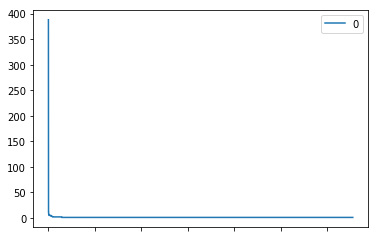

In [80]:
trigrams_counter_df.plot()

In [71]:
print ('Most common bigrams:')
for letter, count in bigrams_counter.most_common(30):
    print ('%s: %7d' % (letter, count))

Most common bigrams:
('topic', 'model'):     751
('topic', 'modeling'):     452
('latent', 'dirichlet'):     398
('dirichlet', 'allocation'):     390
('social', 'medium'):     266
('experimental', 'result'):     167
('social', 'network'):     160
('result', 'show'):     157
('latent', 'topic'):     145
('paper', 'propose'):     128
('proposed', 'method'):     113
('text', 'mining'):     103
('paper', 'present'):      96
('latent', 'semantic'):      89
('probabilistic', 'topic'):      85
('information', 'retrieval'):      82
('machine', 'learning'):      81
('semantic', 'analysis'):      73
('text', 'analysis'):      71
('topic', 'modelling'):      70
('sentiment', 'analysis'):      70
('allocation', 'model'):      69
('natural', 'language'):      67
('show', 'proposed'):      64
('proposed', 'approach'):      62
('topic', 'distribution'):      62
('research', 'topic'):      60
('propose', 'novel'):      60
('case', 'study'):      59
('using', 'topic'):      58


In [72]:
bigrams_counter_dict =  dict(bigrams_counter)

In [73]:
bigrams_counter_df = pd.DataFrame.from_dict(bigrams_counter_dict, orient='index')

In [74]:
bigrams_counter_df = bigrams_counter_df.sort_values(by=[0],ascending=False
                                                     )

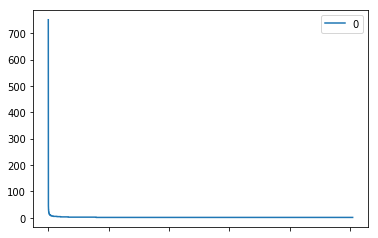

In [75]:
bigrams_counter_df.plot()

# collapse phrases; to collapse phrases, include in this list, then run the code
phrases_to_collapse = [ ]

processed_docs_r = []  
for doc in processed_docs_as_string:
    for phrase in phrases_to_collapse:
        phrase_with_underscore = phrase.replace(" ", "_")
        doc = doc.replace(phrase, phrase_with_underscore)
    processed_docs_r.append(doc.split(" "))

### LDA methods

In [82]:
# work with Mallet wrapper in Gensim
from gensim.models.wrappers import LdaMallet
path_to_mallet_binary = home_path+"/Dev_stuff/mallet-2.0.8/bin/mallet"

In [83]:
# Filter out tokens that appear in: i) less than 15 documents (absolute number) or ii) more than 0.5 documents (fraction of total corpus size, not absolute number).
#dictionary = dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [84]:
# Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.
dictionary = gensim.corpora.Dictionary(processed_docs)

In [85]:
# Gensim doc2bow
# For each document we create a dictionary reporting how many words and how many times those words appear. Save this to ‘bow_corpus’
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

Now, actually doing the LDA

In [86]:
def generateModelCoherence(corpus, dictionary,processed_docs,step=5, start=5, end=10):
    # output a pandas dataframe with each row as a model; num_topics, coherence, model    
    i = 0
    num_topics = (i * step)+start
    models = []
    while num_topics<end:
        num_topics = i * step+start
        print ("num_topics:", num_topics)
        lda_model_mallet = LdaMallet(path_to_mallet_binary, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        cm = CoherenceModel(model=lda_model_mallet ,texts=processed_docs, corpus=corpus,dictionary=dictionary, coherence='c_v')
        print ("coherence:",cm.get_coherence())
        model_specs = {"num_topics":num_topics, "model":lda_model_mallet, "coherence":cm.get_coherence()}
        models.append(model_specs)
        i+=1 # increment step
    return pd.DataFrame(models)

In [87]:
all_models = generateModelCoherence(corpus, dictionary,processed_docs,5,10,100)

num_topics: 10
coherence: 0.4447861867306737
num_topics: 15
coherence: 0.45043367356896896
num_topics: 20
coherence: 0.4206971304981031
num_topics: 25
coherence: 0.40981001872534334
num_topics: 30
coherence: 0.400960810595453
num_topics: 35
coherence: 0.3993084243775669
num_topics: 40
coherence: 0.3874705882122679
num_topics: 45
coherence: 0.3799981960432084
num_topics: 50
coherence: 0.37963631217034327
num_topics: 55
coherence: 0.37269739475621866
num_topics: 60
coherence: 0.3650145496546912
num_topics: 65
coherence: 0.3733893728511426
num_topics: 70
coherence: 0.3685805181392735
num_topics: 75
coherence: 0.3635275114832314
num_topics: 80
coherence: 0.35936575812100574
num_topics: 85
coherence: 0.3527253301033179
num_topics: 90
coherence: 0.3550447758948038
num_topics: 95
coherence: 0.3521551356752643
num_topics: 100
coherence: 0.35219059171140743


In [88]:
len(all_models)

19

In [89]:
all_models

,coherence,model,num_topics
0,0.444786,<gensim.models.wrappers.ldamallet.LdaMallet ob...,10
1,0.450434,<gensim.models.wrappers.ldamallet.LdaMallet ob...,15
2,0.420697,<gensim.models.wrappers.ldamallet.LdaMallet ob...,20
3,0.409810,<gensim.models.wrappers.ldamallet.LdaMallet ob...,25
4,0.400961,<gensim.models.wrappers.ldamallet.LdaMallet ob...,30
5,0.399308,<gensim.models.wrappers.ldamallet.LdaMallet ob...,35
6,0.387471,<gensim.models.wrappers.ldamallet.LdaMallet ob...,40
7,0.379998,<gensim.models.wrappers.ldamallet.LdaMallet ob...,45
8,0.379636,<gensim.models.wrappers.ldamallet.LdaMallet ob...,50
9,0.372697,<gensim.models.wrappers.ldamallet.LdaMallet ob...,55


In [94]:
all_models = all_models.set_index('num_topics')

In [95]:
all_models.head()

,coherence,model
num_topics,,
10,0.444786,<gensim.models.wrappers.ldamallet.LdaMallet ob...
15,0.450434,<gensim.models.wrappers.ldamallet.LdaMallet ob...
20,0.420697,<gensim.models.wrappers.ldamallet.LdaMallet ob...
25,0.409810,<gensim.models.wrappers.ldamallet.LdaMallet ob...
30,0.400961,<gensim.models.wrappers.ldamallet.LdaMallet ob...


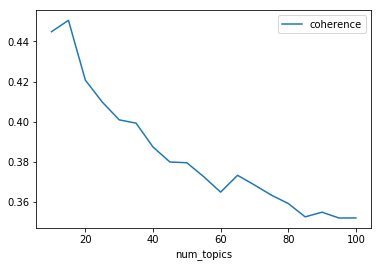

In [96]:
models_to_plot = all_models.copy() 
models_to_plot = models_to_plot.drop(columns=['model'])
models_to_plot.plot()

From this, the optimal topics could be 15 or 65

## Saving 15 topics

In [99]:
lda_model_mallet_15 = all_models.loc[15]['model']
lda_model_mallet_15.save("lda_model_15_topics_Jun2018_Analysis.sav")
path_state_file_for_lda_model = lda_model_mallet_15.fstate()
shutil.copy2(path_state_file_for_lda_model, "./lda_model_15_topics_file_Jun2018_Analysis.gzip")

path_doc_topics_for_lda_model = lda_model_mallet_15.fdoctopics() 
shutil.copy2(path_doc_topics_for_lda_model, "./lda_model_15_doc_topics_file_Jun2018_Analysis.txt")

'./lda_model_15_doc_topics_file_Jun2018_Analysis.txt'

## Saving 65 topics

In [100]:
lda_model_mallet_65 = all_models.loc[65]['model']
lda_model_mallet_65.save("lda_model_65_topics_Jun2018_Analysis.sav")
path_state_file_for_lda_model = lda_model_mallet_65.fstate()
shutil.copy2(path_state_file_for_lda_model, "./lda_model_65_topics_file_Jun2018_Analysis.gzip")

path_doc_topics_for_lda_model = lda_model_mallet_65.fdoctopics() 
shutil.copy2(path_doc_topics_for_lda_model, "./lda_model_65_doc_topics_file_Jun2018_Analysis.txt")

'./lda_model_65_doc_topics_file_Jun2018_Analysis.txt'

## Start to inspect topics

In [98]:
lda_model_mallet_15.show_topics(15)

[(19,
  '0.090*"evaluation" + 0.072*"order" + 0.047*"page" + 0.043*"view" + 0.037*"concern" + 0.034*"rate" + 0.023*"point" + 0.021*"book" + 0.021*"conducted" + 0.018*"statistic"'),
 (73,
  '0.030*"information" + 0.027*"social" + 0.026*"effect" + 0.021*"network" + 0.021*"service" + 0.013*"management" + 0.013*"role" + 0.012*"project" + 0.010*"user" + 0.010*"impact"'),
 (22,
  '0.063*"business" + 0.055*"company" + 0.050*"consumer" + 0.042*"market" + 0.040*"potential" + 0.030*"firm" + 0.030*"industry" + 0.026*"competitive" + 0.025*"framework" + 0.022*"strategy"'),
 (53,
  '0.094*"science" + 0.067*"analysis" + 0.054*"research" + 0.041*"software" + 0.031*"engineering" + 0.030*"computer" + 0.025*"skill" + 0.023*"technique" + 0.020*"practice" + 0.019*"developed"'),
 (44,
  '0.094*"area" + 0.064*"patent" + 0.052*"urban" + 0.042*"analysis" + 0.035*"study" + 0.028*"elsevier" + 0.026*"planning" + 0.019*"functional" + 0.018*"case" + 0.018*"land"'),
 (9,
  '0.184*"review" + 0.086*"service" + 0.085*"

In [101]:
lda_model_mallet_65.show_topics(65)

[(0,
  '0.383*"information" + 0.056*"based" + 0.037*"source" + 0.037*"paper" + 0.029*"order" + 0.026*"internet" + 0.024*"specific" + 0.019*"provide" + 0.018*"framework" + 0.018*"extracted"'),
 (1,
  '0.043*"sample" + 0.027*"patient" + 0.026*"health" + 0.023*"treatment" + 0.020*"medical" + 0.020*"higher" + 0.019*"results" + 0.019*"clinical" + 0.019*"condition" + 0.018*"increase"'),
 (2,
  '0.086*"change" + 0.057*"issue" + 0.037*"policy" + 0.032*"understanding" + 0.029*"climate" + 0.028*"public" + 0.024*"development" + 0.023*"individual" + 0.021*"find" + 0.021*"energy"'),
 (3,
  '0.090*"activity" + 0.079*"post" + 0.041*"candidate" + 0.031*"place" + 0.026*"blog" + 0.020*"political" + 0.020*"online" + 0.020*"modeling" + 0.019*"individual" + 0.018*"focus"'),
 (4,
  '0.233*"model" + 0.054*"show" + 0.047*"task" + 0.046*"propose" + 0.043*"proposed" + 0.040*"outperforms" + 0.034*"capture" + 0.029*"baseline" + 0.028*"state-of-the-art" + 0.023*"experiment"'),
 (5,
  '0.086*"evaluation" + 0.085*"r

# Next, in another Notebook, process the output of these models